In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
import os

DIR = "../data/"
CONT_COL = "CONT"

/home/mee5vc/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df = pd.read_csv('../data/distribution/merged_filtered.csv')
df = df[df[CONT_COL] > 0]

# ---- we should consider which territories to keep in -------------------
# remove territories
to_remove = ['AS', 'FO', 'FM', 'GU', 'MH', 'MP', 'PR', 'VI']
df = df[(df['STATE'].isna() == False)]
for st in to_remove:
    df = df[df['STATE'] != st]
# ------------------------------------------------------------------------

In [ ]:
print(df[CONT_COL].describe())
df[CONT_COL].plot(kind='kde')

In [3]:
# remove outliers
q1 = df[CONT_COL].quantile(0.25)
q3 = df[CONT_COL].quantile(0.75)
iqr = q3 - q1
low = q1 - 1.5 * iqr
high = q3 + 1.5 * iqr
df = df[(df[CONT_COL] < high)]

In [ ]:
print(df[CONT_COL].describe())
df[CONT_COL].plot(kind='kde')

Adjusting for inflation... would love for someone to check my work here to make sure I'm doing this right.

In [19]:
# adjusting for inflation in terms of 2022
path = os.path.join(DIR, 'distribution', 'cpi_all.csv')
cpi = pd.read_csv(path)
cpi['fis_yr'] = cpi['Year'].apply(lambda x: x + 1)

cpi = cpi[['fis_yr', 'Annual']]
years = df['FISYR'].unique().tolist()

infl_adj = None
diff = max(cpi['fis_yr'].unique()) - max(df['FISYR'].unique())
pct_rate = sum([cpi.loc[i, 'Annual'] for i in range(len(cpi) - int(diff), len(cpi))]) / 100

for i in range(len(years) - 1, -1, -1):
    pct_rate += cpi.loc[i, 'Annual'] / 100
    temp = df[df['FISYR'] == years[i]].copy()
    temp[CONT_COL] = temp[CONT_COL].apply(lambda x: x * (pct_rate + 1))
    #temp['SOLICIT'] = temp['SOLICIT'].apply(lambda x: x * (pct_rate + 1))
    infl_adj = pd.concat([infl_adj, temp])

In [20]:
total_conts = df[['FISYR', CONT_COL]].groupby('FISYR').sum().reset_index()
total_conts_adj = infl_adj[['FISYR', CONT_COL]].groupby('FISYR').sum().reset_index()

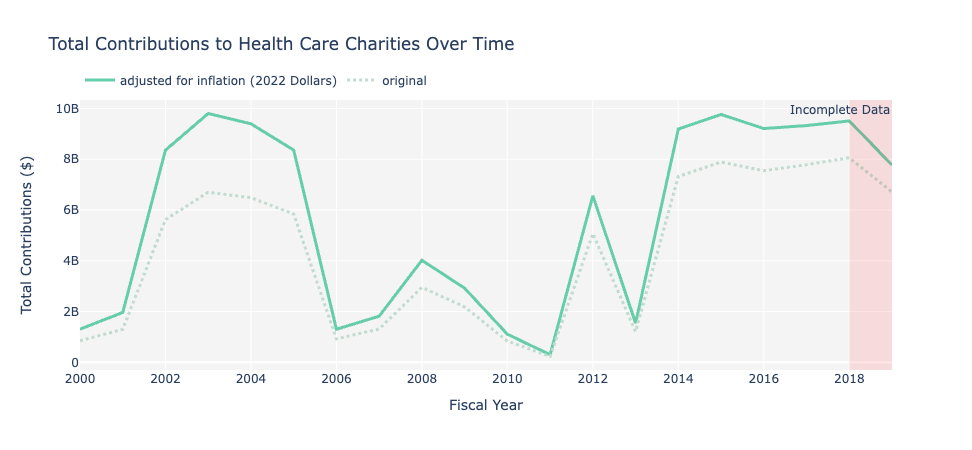

In [21]:
# contributions plot
fig = go.Figure()

line1 = go.Scatter(x=total_conts_adj['FISYR'], y=total_conts_adj[CONT_COL], name='adjusted for inflation (2022 Dollars)', 
                   yaxis='y1', line = dict(color = ('mediumaquamarine'), width = 3))
line2 = go.Scatter(x=total_conts['FISYR'], y=total_conts[CONT_COL], name='original', yaxis='y1',
                   line = dict(color = ('rgba(193, 220, 207, 1)'), width = 3, dash='dot'))

fig.add_trace(line1)
fig.add_trace(line2)

fig.add_vrect(x0=max(total_conts['FISYR'].tolist()) - 1, x1=max(total_conts['FISYR'].tolist()), 
              annotation= dict(text="Incomplete Data"),
              fillcolor="red", opacity=0.1, line_width=0, name="incomplete data")

fig.update_layout(
    title='Total Contributions to Health Care Charities Over Time',
    xaxis_title='Fiscal Year',
    yaxis_title='Total Contributions ($)',
    plot_bgcolor='rgba(200, 200, 200, 0.2)',
    legend=dict(
        orientation="h",
        entrywidth=70,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0)
    ) 
fig.show()

# expenses plot
#fig = go.Figure()
#fig.add_trace(go.Scatter(x=fund_exp['FISYR'], y=fund_exp['SOLICIT'], name='fundraising expenses',
#                   line = dict(color = ('lightcoral'), width = 3)))

#fig.add_vrect(x0=max(total_conts['FISYR'].tolist()) - 1, x1=max(total_conts['FISYR'].tolist()), 
 #             annotation= dict(text="Incomplete Data"),
 #             fillcolor="red", opacity=0.1, line_width=0, name="incomplete data")

#fig.update_layout(
 #   title='Total Fundraising Expenses of Health Care Charities Over Time',
 #   xaxis_title='Fiscal Year',
 #   yaxis_title='Total Expenses ($)',
 #   plot_bgcolor='rgba(200, 200, 200, 0.2)',
 #   legend=dict(
 #       orientation="h",
 #       entrywidth=70,
 #       yanchor="bottom",
 #       y=1.02,
 #       xanchor="left",
 #       x=0)
 #   ) 
#fig.show()

ECONOMIC DATA

In [22]:
ECON_PATH = "../data/distribution/econ_indicators"

econ_df = pd.read_csv(os.path.join(ECON_PATH, "econ_indicators_processed.csv"))
econ_df['fis_yr'] = econ_df['year'].apply(lambda x : x + 1)

# clean data
econ_df = econ_df[(econ_df['fis_yr'] >= min(df['FISYR'].unique())) & (econ_df['fis_yr'] <= max(df['FISYR'].unique()))]
econ_df = econ_df.drop(['month', 'year'], axis=1).reset_index(drop=True)

econ_df['dow_jones_adj_close'] = econ_df['dow_jones_adj_close'].apply(lambda x: x.replace(',', '')).astype(float)

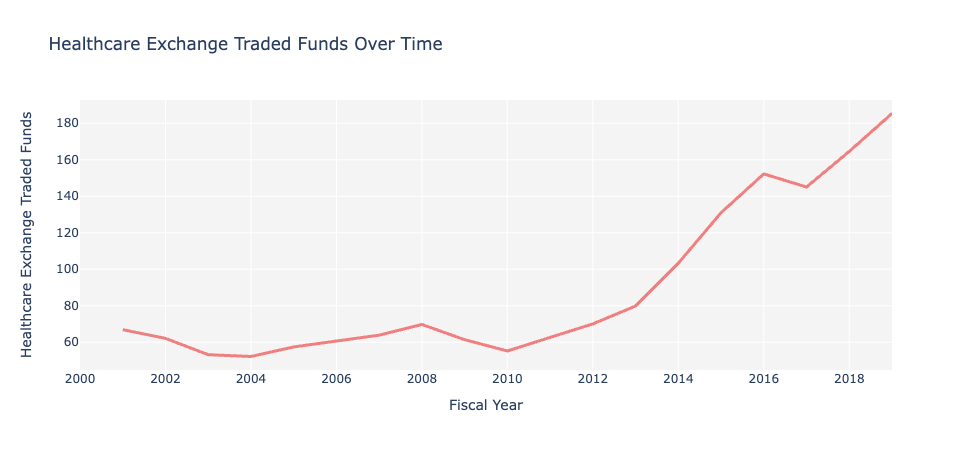

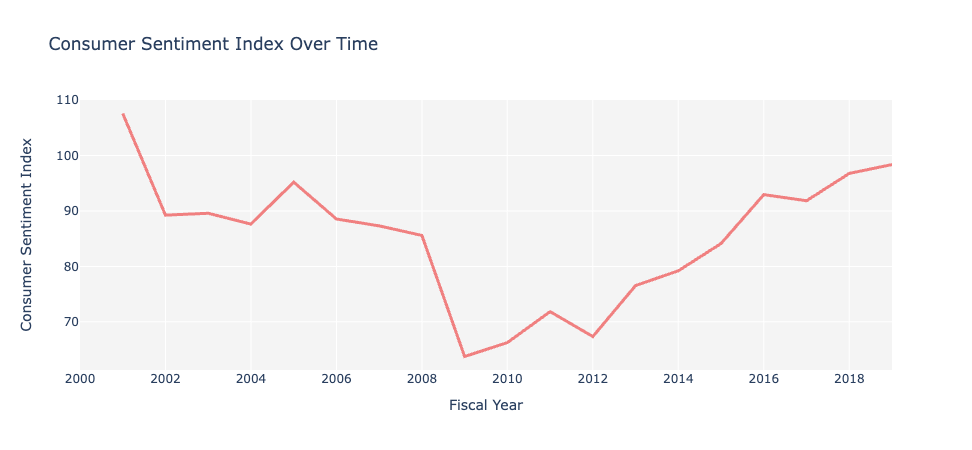

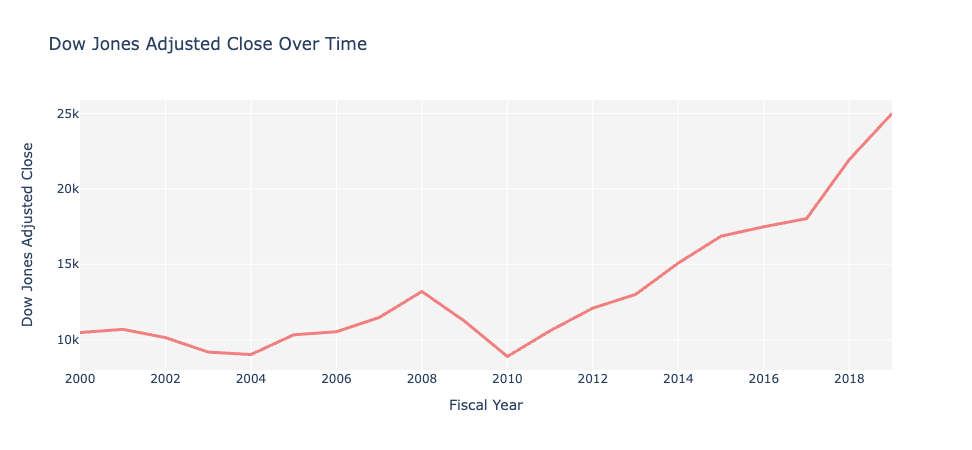

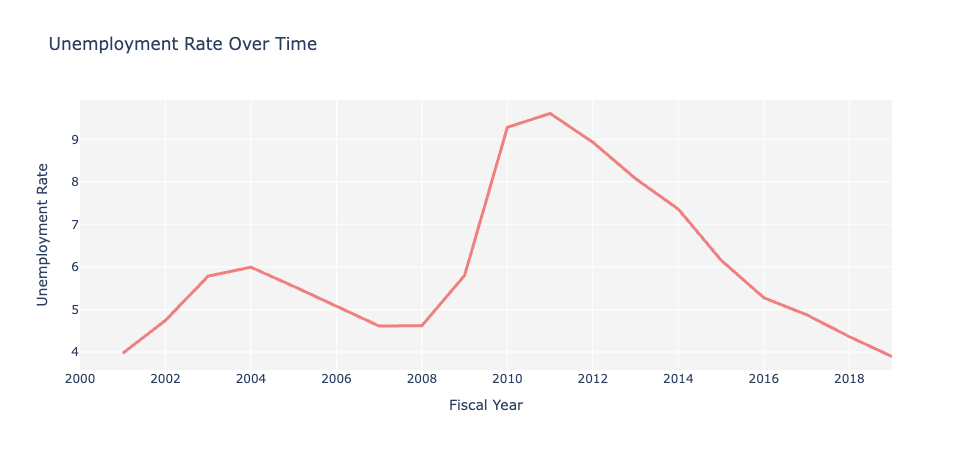

In [23]:
titles = {'healthcare_etf': 'Healthcare Exchange Traded Funds', 'consumer_sentiment_index': 'Consumer Sentiment Index',
         'dow_jones_adj_close': 'Dow Jones Adjusted Close', 'unemployment_rate': 'Unemployment Rate'}

grouped = econ_df.groupby('fis_yr').mean().reset_index()

# plot for each indicator
for col in grouped.columns[1:]:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=grouped['fis_yr'], y=grouped[col], name=col,
                   line = dict(color = ('lightcoral'), width = 3)))

    fig.update_layout(
        title=titles[col] + ' Over Time',
        xaxis_title='Fiscal Year',
        yaxis_title=titles[col],
        plot_bgcolor='rgba(200, 200, 200, 0.2)'
    ) 
    fig.show()